# 3D trajectories in a turbulent field

The following simulation tracks a single UHE nucleus and its secondary nucleons/nuclei through a turbulent magnetic field.

First we create a random realization of a turbulent field with a Kolmogorov power spectrum on 60-800 kpc lengthscales and an RMS field strength of 8 nG.
The field is stored on a $256^3$ grid with 30 kpc grid spacing, and thus has an extent of $(256 \cdot 30 \rm{kpc})^3$.
The field is by default periodically repeated in space to cover an arbitrary volume.

The chosen grid size consumes only very little memory. For practical purposes a larger grid is advised in order to represent more variations of turbulent modes, provide a larger turbulent range, or a higher resolution.

In [1]:
from crpropa import *

randomSeed = 42
Brms=8*nG
lMin = 60*kpc
lMax=800*kpc
sIndex=5./3.
turbSpectrum = SimpleTurbulenceSpectrum(Brms, lMin, lMax, sIndex)
gridprops = GridProperties(Vector3d(0), 256, 30*kpc)
BField = SimpleGridTurbulence(turbSpectrum, gridprops, randomSeed)

In [2]:
# print some properties of our field
print('Lc = {:.1f} kpc'.format(BField.getCorrelationLength() / kpc))  # correlation length
print('sqrt(<B^2>) = {:.1f} nG'.format(BField.getBrms() / nG))   # RMS
print('<|B|> = {:.1f} nG'.format(BField.getMeanFieldStrength() / nG))  # mean
print('B(10 Mpc, 0, 0) =', BField.getField(Vector3d(10,0,0) * Mpc) / nG, 'nG')

Lc = 192.0 kpc
sqrt(<B^2>) = 8.0 nG
<|B|> = 7.4 nG
B(10 Mpc, 0, 0) = Vector(0.21059, -1.94174, 1.69713) nG


### Saving and loading fields

In addition to creating random turbulent fields, we can also load and save custom magnetic field grids.
As input and output we currently support binary files in single precision and ASCII files.

In [3]:
# save the field
# format: (Bx, By, Bz)(x, y, z) with z changing the quickest.
dumpGrid(BField.getGrid(), 'myfield.dat')       # binary, single precision
dumpGridToTxt(BField.getGrid(), 'myfield.txt')  # ASCII
# load your own field
vgrid=Grid3f(gridprops)
loadGrid(vgrid, 'myfield.dat')
loadGridFromTxt(vgrid, 'myfield.txt')

### Running the simulation
Now that we have our magnetic field ready we can fire up our simulation and hope that something visually interesting is going to happen.

In [4]:
sim = ModuleList()
sim.add(PropagationCK(BField))
sim.add(PhotoPionProduction(CMB()))
sim.add(PhotoPionProduction(IRB_Kneiske04()))
sim.add(PhotoDisintegration(CMB()))
sim.add(PhotoDisintegration(IRB_Kneiske04()))
sim.add(ElectronPairProduction(CMB()))
sim.add(ElectronPairProduction(IRB_Kneiske04()))
sim.add(NuclearDecay())
sim.add(MaximumTrajectoryLength(25 * Mpc))
output = TextOutput('trajectory.txt', Output.Trajectory3D) 
sim.add(output)

x = Vector3d(0,0,0)  # position
p = Vector3d(1,1,0)  # direction
c = Candidate(nucleusId(16, 8), 100 * EeV, x, p)

sim.run(c, True)

### (Optional) Plotting

We plot the trajectory of our oxygen-16 nucleus. To distinguish between secondary nuclei the following colors are used: protons are blue, alpha particles are green, everthing heavier is red.

/tmp/ipykernel_961678/2311979340.py:22: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')# , aspect='equal'


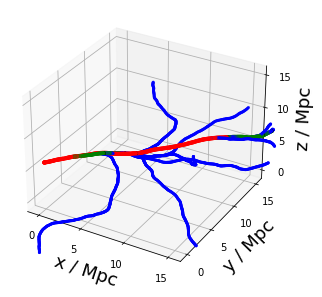

In [5]:
%matplotlib inline
from pylab import *
from mpl_toolkits.mplot3d import axes3d

output.close()
data = genfromtxt('trajectory.txt', names=True)

# trajectory points
x, y, z = data['X'], data['Y'], data['Z']

# translate particle ID to charge number
Z = [chargeNumber(int(Id)) for Id in data['ID'].astype(int)]

# translate the charge number to color and size
# --> protons are blue, Helium is green, everthing else is red
colorDict = {0:'k', 1:'b', 2:'g', 3:'r', 4:'r', 5:'r', 6:'r', 7:'r', 8:'r'}
sizeDict = {0:4, 1:4, 2:8, 3:10, 4:10, 5:10, 6:10, 7:10, 8:10}
colors = [colorDict[z] for z in Z]
sizes  = [sizeDict[z] for z in Z]

fig = plt.figure(figsize=(12, 5))#plt.figaspect(0.5))
ax = fig.gca(projection='3d')# , aspect='equal'

ax.scatter(x,y,z+6, 'o', s=sizes, color=colors)

ax.set_xlabel('x / Mpc', fontsize=18)
ax.set_ylabel('y / Mpc', fontsize=18)
ax.set_zlabel('z / Mpc', fontsize=18)
ax.set_xlim((-1, 16))
ax.set_ylim((-1, 16))
ax.set_zlim((-1, 16))
ax.xaxis.set_ticks((0, 5, 10, 15))
ax.yaxis.set_ticks((0, 5, 10, 15))
ax.zaxis.set_ticks((0, 5, 10, 15))

show()